# Density Tree for N-dimensional data and labels
The code below implements a **density** tree for non-labelled data.

## Libraries
First, some libraries are loaded and global figure settings are made for exporting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from IPython.core.display import Image, display

# Custom Libraries
from density_tree.density_forest import *
from density_tree.density_tree_create import *
from density_tree.density_tree_traverse import *
from density_tree.create_data import *
from density_tree.helpers import *
from density_tree.plots import *

/opt/conda/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Generate Data

First, let's generate some unlabelled data:


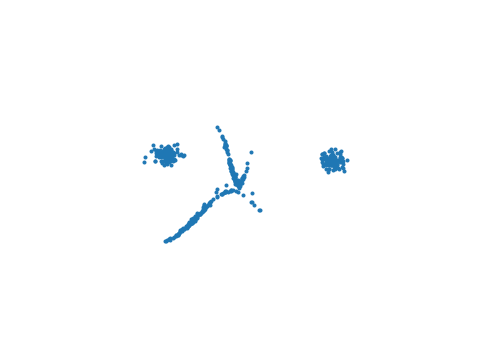

In [20]:
# dataset
d_id = 1
dimensions = 2


# Dataset 1: Random Points
if d_id == 1:
    nclusters = 4
    covariance = 5
    npoints = 1200
    margin = 20  # for plots
    minRange = 0
    maxRange = 100

    dataset = create_data(nclusters, dimensions, covariance, npoints, 
                          minrange=minRange, maxrange=maxRange,
                          labelled=False, random_flip=True, 
                          nonlinearities=True)

    if dimensions == 2:
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(8,6)
        plot_data(draw_subsamples(dataset, .1), ax, labels=False, minrange=minRange, maxrange=maxRange, margin=30)
        plt.axis('off')
        plt.savefig("../Figures/density_tree/D" + str(d_id) + "_data.pdf", bbox_inches='tight', pad_inches=0)

        plt.show()

# Dataset 2: Fermat Spiral        
elif d_id==2:
    margin = 0  # for plots
    dataset, minRange, maxRange = create_spirals(n_points_arm=1000,
                                                 radius_min=np.pi / 50,
                                                 radius_max=7 * np.pi / 16,
                                                 divergence=0.05,
                                                 n_arms=4)
    
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    subset = draw_subsamples(dataset, .1)
    ax.scatter(subset[...,0],subset[...,1], marker='.')
    plt.savefig("../Figures/density_tree/D" + str(d_id) + "_data.pdf", bbox_inches='tight', pad_inches=0)
    
    
# Dataset 3: S-shape
elif d_id==3:
    margin = 0  # for plots
    dataset, minRange, maxRange = create_S_shape(n_points_arm=3000, 
                                                 radius_min=np.pi / 4, 
                                                 radius_max=6 * np.pi / 4, 
                                                 divergence=0.05)


    fig = plt.figure(figsize=(5,5))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    subset = draw_subsamples(dataset, 1)
    ax.scatter(subset[...,0],subset[...,1], marker='.')
    plt.savefig("../Figures/density_tree/D" + str(d_id) + "_data.pdf", bbox_inches='tight', pad_inches=0)

In [21]:
from ipywidgets import interact, FloatSlider
def fig(begin, end):
    ind = np.arange(begin,end)
    plt.scatter(dataset[ind,0],dataset[ind,1])
    plt.title("Entropy: %.3f" % entropy_gaussian(dataset[ind]))


min_ = 0
max_ = 5000
step_= 20
# max_ = len(dataset)
interact(fig,begin=(min_-step_,max_,step_),end=(min_,max_,step_))


interactive(children=(IntSlider(value=2480, description='begin', max=5000, min=-20, step=20), IntSlider(value=2500, description='end', max=5000, step=20), Output()), _dom_classes=('widget-interact',))

<function __main__.fig>

#### Create single Density Tree

Dataset size: 4800
Minimum number of points in each leaf: 4


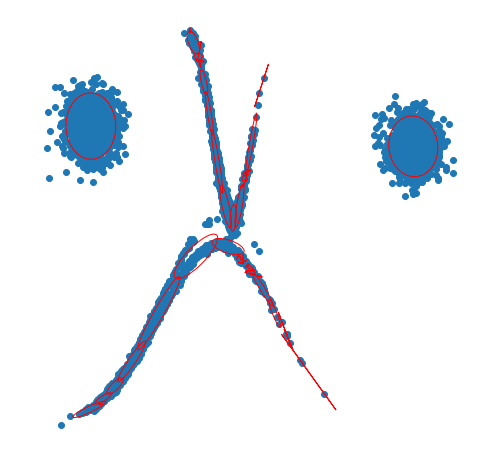

In [22]:
max_depth = 10
fact_improvement = 1.1
min_subset = 0.001
n_dim_max = 0

print("Dataset size: %i" % int(len(dataset)))
print("Minimum number of points in each leaf: %i" % int(len(dataset) * min_subset))

root = create_density_tree(dataset, max_depth=max_depth, min_subset=min_subset, n_max_dim=n_dim_max, 
                           verbose=True, fact_improvement=fact_improvement)

covs, means = get_clusters(root, [], [])    
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8,8)
plt.scatter(dataset[:,0],dataset[:,1])
plot_ellipses(ax, means, covs)
ax.set_title("")
plt.axis('off')
plt.savefig("../Figures/density_tree/D" + str(d_id) + "_data-covs.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [18]:
def get_covs_means_depth(node, depth, means, covs):
    """get covs and means of a tree at a certain depth"""
    if node.get_depth() == depth:
        means.append(node.mean)
        covs.append(node.cov)
    if node.get_depth() <= depth and node.right is None:
        means.append(node.right_mean)
        covs.append(node.right_cov)

    if node.get_depth() <= depth and node.left is None:
        means.append(node.left_mean)
        covs.append(node.left_cov)
        
    if node.left is not None:
        means, covs =  get_covs_means_depth(node.left, depth, means, covs)

    if node.right is not None:
        means, covs = get_covs_means_depth(node.right, depth, means, covs)
    
    return means, covs    

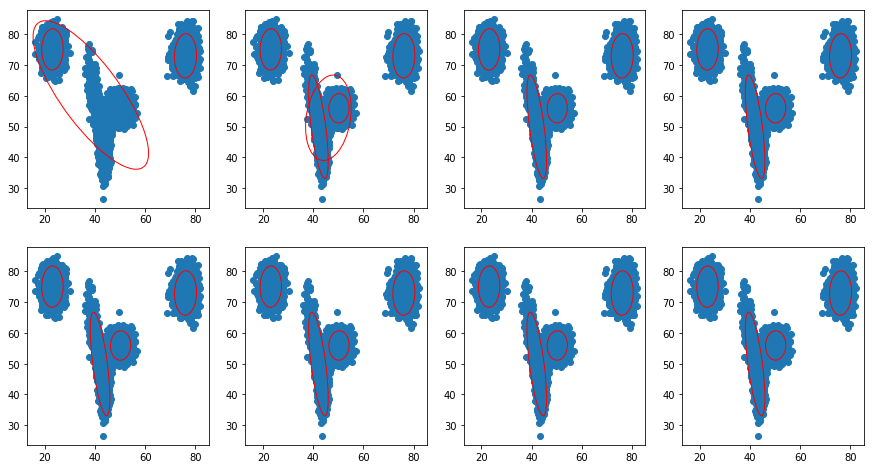

In [19]:
fig, axes = plt.subplots(2, 4)
fig.set_size_inches(15,8)

for i in range(1,5):
    means, covs = get_covs_means_depth(root,i,[],[])
    axes[0][i-1].scatter(dataset[:,0],dataset[:,1])
    plot_ellipses(axes[0][i-1], means, covs)
    
for i in range(5,9):
    means, covs = get_covs_means_depth(root,i,[],[])
    axes[1][i-5].scatter(dataset[:,0],dataset[:,1])
    plot_ellipses(axes[1][i-5], means, covs)

# Printing the Tree

In [7]:
# ATTENTION: requires LaTeX, imagemagick to be installed

def tree_visualize(root):
    tree_string = ""
    tree_string = print_density_tree_latex(root, tree_string)
    cdir = "cd ../Figures/density_tree;"
    
    os.system(cdir + "rm density-tree.tex")
    os.system(cdir + "more main_pt1.tex >> density-tree.tex; echo '' >> density-tree.tex;")
    os.system(cdir + "echo '" + tree_string + "' >> density-tree.tex;  more main_pt2.tex >> density-tree.tex;")
    os.system(cdir + "/Library/TeX/texbin/pdflatex density-tree.tex")
    os.system(cdir + "convert -density 300 -trim density-tree.pdf -quality 100 density-tree.png")
    os.system(cdir + "rm *.aux *.log")
    #display(Image('../Figures/density_tree/density-tree.png', retina=True))
    
tree_visualize(root)

In [8]:
from scipy.stats import multivariate_normal

# loop
def create_plot_surface(minRange, maxRange, roots, n_points_dim=100, standardize=False, thresh=.01):
    """thresh: pct of data in each leaf node"""
    grid = np.linspace(minRange, maxRange, n_points_dim)
    probas_out = np.zeros((n_points_dim,n_points_dim))

    
    for idx_x, pt in tqdm(enumerate(grid)):
        for idx_y, g in enumerate(grid):
            proba_pt=[]
            for root in roots:
                # descend tree
                d_mean, d_pct, d_pdf_mean, d_cov_det, d_cov_inv = descend_density_tree([pt, g], root)
                # probability for this point to be from this distribution
                if d_pct>thresh:
                    try:
                        mn = my_normal(np.asarray([pt, g]), d_mean, d_cov_det, d_cov_inv)
                        if standardize: 
                            mn /= d_pdf_mean
                        proba_pt.append(mn)
                    except:
                        proba_pt.append(np.nan)

                
            probas_out[idx_x, idx_y] = np.nanmean(proba_pt)

    return probas_out

In [9]:
probas = create_plot_surface(minRange-margin, maxRange+margin, [root], n_points_dim=150, standardize=False, thresh=0)
probas = np.flipud(probas.T)

150it [00:01, 109.01it/s]


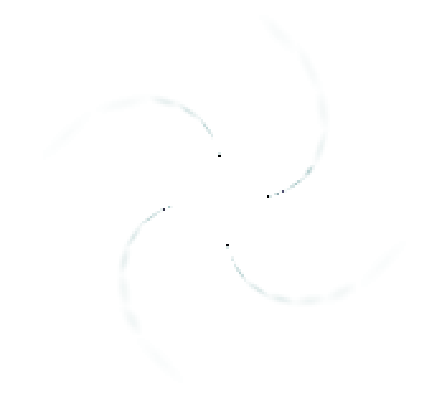

In [10]:
fig = plt.figure(figsize=(7,7))
plt.imshow(1-probas, cmap='bone')
plt.axis('off')
plt.savefig("../Figures/density_tree/D" + str(d_id) + "_one_tree.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

#### Density Forest

In [11]:
n_trees = 20
subsample_pct = .2
min_subset = .01
n_jobs = -1
n_max_dim = -1
max_depth = 4

root_nodes = df_create(dataset, max_depth=max_depth, min_subset=min_subset, 
                                   n_trees=n_trees, subsample_pct=subsample_pct, n_max_dim=n_max_dim, 
                                   n_jobs=n_jobs, fact_improvement=fact_improvement)

Number of points on which to train each tree: 3200
Minimum number of points in each leaf: 32


[Parallel(n_jobs=40)]: Done   4 out of  20 | elapsed:    2.4s remaining:    9.6s


Number of created root nodes: 20
Mean number of clusters created per tree: 26


[Parallel(n_jobs=40)]: Done  20 out of  20 | elapsed:    2.7s finished


In [12]:
root_nodes = np.asarray(root_nodes)
root_nodes = root_nodes[np.not_equal(root_nodes, None)]

150it [00:07, 19.85it/s]


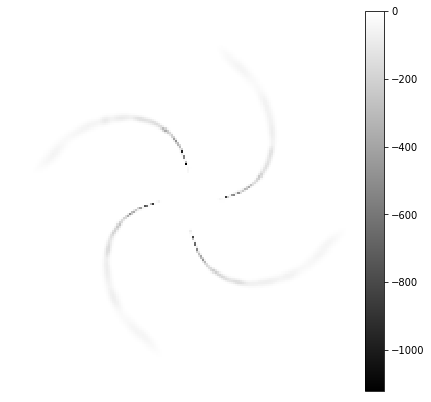

In [13]:
probas = create_plot_surface(minRange-margin, maxRange+margin, root_nodes, n_points_dim=150, standardize=False, thresh=0)
probas = np.flipud(probas.T)

fig = plt.figure(figsize=(7,7))
plt.imshow(1-probas, cmap='gray')
plt.axis('off')
plt.savefig("../Figures/density_tree/D" + str(d_id) + "_DF_forest.pdf", bbox_inches='tight', pad_inches=0)
plt.colorbar()

150it [00:07, 20.29it/s]


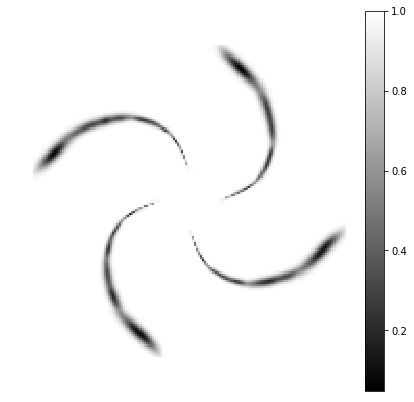

In [14]:
# standardized version
probas = create_plot_surface(minRange-margin, maxRange+margin, root_nodes, n_points_dim=150, standardize=True, thresh=.001)
probas = np.flipud(probas.T)

fig = plt.figure(figsize=(7,7))
plt.imshow(1-probas, cmap='gray')
plt.axis('off')
plt.savefig("../Figures/density_tree/D" + str(d_id) + "_DF_stand.pdf", bbox_inches='tight', pad_inches=0)
plt.colorbar()